In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[66049:92469] 
Y_train_SS = Y_train_SS[66049:92469]
Y_train_V = Y_train_V[66049:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 26420
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 26420 samples, validate on 13210 samples
Epoch 1/100
26400/26420 [============================>.] - ETA: 0s - loss: 0.0571 - dense_5_loss: 0.0439 - dense_6_loss: 0.0132 - dense_5_mse: 0.0439 - dense_6_mse: 0.0132

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02954, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


26420/26420 [==============================] - 7s 246us/sample - loss: 0.0571 - dense_5_loss: 0.0439 - dense_6_loss: 0.0132 - dense_5_mse: 0.0439 - dense_6_mse: 0.0132 - val_loss: 0.0295 - val_dense_5_loss: 0.0126 - val_dense_6_loss: 0.0169 - val_dense_5_mse: 0.0126 - val_dense_6_mse: 0.0169
Epoch 2/100
26420/26420 [==============================] - ETA: 0s - loss: 0.0195 - dense_5_loss: 0.0064 - dense_6_loss: 0.0131 - dense_5_mse: 0.0064 - dense_6_mse: 0.0131
Epoch 2: val_loss improved from 0.02954 to 0.02392, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


26420/26420 [==============================] - 4s 158us/sample - loss: 0.0195 - dense_5_loss: 0.0064 - dense_6_loss: 0.0131 - dense_5_mse: 0.0064 - dense_6_mse: 0.0131 - val_loss: 0.0239 - val_dense_5_loss: 0.0070 - val_dense_6_loss: 0.0169 - val_dense_5_mse: 0.0070 - val_dense_6_mse: 0.0169
Epoch 3/100
26176/26420 [============================>.] - ETA: 0s - loss: 0.0158 - dense_5_loss: 0.0034 - dense_6_loss: 0.0124 - dense_5_mse: 0.0034 - dense_6_mse: 0.0124
Epoch 3: val_loss improved from 0.02392 to 0.02361, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


26420/26420 [==============================] - 4s 160us/sample - loss: 0.0158 - dense_5_loss: 0.0034 - dense_6_loss: 0.0124 - dense_5_mse: 0.0034 - dense_6_mse: 0.0124 - val_loss: 0.0236 - val_dense_5_loss: 0.0078 - val_dense_6_loss: 0.0158 - val_dense_5_mse: 0.0078 - val_dense_6_mse: 0.0159
Epoch 4/100
25888/26420 [============================>.] - ETA: 0s - loss: 0.0100 - dense_5_loss: 0.0035 - dense_6_loss: 0.0065 - dense_5_mse: 0.0035 - dense_6_mse: 0.0065
Epoch 4: val_loss improved from 0.02361 to 0.00856, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


26420/26420 [==============================] - 4s 157us/sample - loss: 0.0100 - dense_5_loss: 0.0035 - dense_6_loss: 0.0066 - dense_5_mse: 0.0035 - dense_6_mse: 0.0066 - val_loss: 0.0086 - val_dense_5_loss: 0.0045 - val_dense_6_loss: 0.0041 - val_dense_5_mse: 0.0045 - val_dense_6_mse: 0.0041
Epoch 5/100
26400/26420 [============================>.] - ETA: 0s - loss: 0.0066 - dense_5_loss: 0.0026 - dense_6_loss: 0.0040 - dense_5_mse: 0.0026 - dense_6_mse: 0.0040
Epoch 5: val_loss improved from 0.00856 to 0.00709, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


26420/26420 [==============================] - 4s 154us/sample - loss: 0.0066 - dense_5_loss: 0.0026 - dense_6_loss: 0.0040 - dense_5_mse: 0.0026 - dense_6_mse: 0.0040 - val_loss: 0.0071 - val_dense_5_loss: 0.0028 - val_dense_6_loss: 0.0043 - val_dense_5_mse: 0.0028 - val_dense_6_mse: 0.0043
Epoch 6/100
26144/26420 [============================>.] - ETA: 0s - loss: 0.0056 - dense_5_loss: 0.0021 - dense_6_loss: 0.0035 - dense_5_mse: 0.0021 - dense_6_mse: 0.0035
Epoch 6: val_loss did not improve from 0.00709
26420/26420 [==============================] - 4s 137us/sample - loss: 0.0056 - dense_5_loss: 0.0021 - dense_6_loss: 0.0035 - dense_5_mse: 0.0021 - dense_6_mse: 0.0035 - val_loss: 0.0094 - val_dense_5_loss: 0.0065 - val_dense_6_loss: 0.0029 - val_dense_5_mse: 0.0065 - val_dense_6_mse: 0.0029
Epoch 7/100
26272/26420 [============================>.] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0020 - dense_6_loss: 0.0030 - dense_5_mse: 0.0020 - dense_6_mse: 0.0030
Epoch 7: val_loss did n

26420/26420 [==============================] - 4s 167us/sample - loss: 0.0045 - dense_5_loss: 0.0018 - dense_6_loss: 0.0027 - dense_5_mse: 0.0018 - dense_6_mse: 0.0027 - val_loss: 0.0053 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0031
Epoch 9/100
26112/26420 [============================>.] - ETA: 0s - loss: 0.0061 - dense_5_loss: 0.0020 - dense_6_loss: 0.0040 - dense_5_mse: 0.0020 - dense_6_mse: 0.0040
Epoch 9: val_loss did not improve from 0.00533
26420/26420 [==============================] - 3s 132us/sample - loss: 0.0060 - dense_5_loss: 0.0020 - dense_6_loss: 0.0040 - dense_5_mse: 0.0020 - dense_6_mse: 0.0040 - val_loss: 0.0066 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0036 - val_dense_5_mse: 0.0030 - val_dense_6_mse: 0.0036
Epoch 10/100
26400/26420 [============================>.] - ETA: 0s - loss: 0.0043 - dense_5_loss: 0.0017 - dense_6_loss: 0.0026 - dense_5_mse: 0.0017 - dense_6_mse: 0.0026
Epoch 10: val_loss did

26420/26420 [==============================] - 5s 206us/sample - loss: 0.0035 - dense_5_loss: 0.0015 - dense_6_loss: 0.0020 - dense_5_mse: 0.0015 - dense_6_mse: 0.0020 - val_loss: 0.0046 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0024
Epoch 12/100
25984/26420 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022
Epoch 12: val_loss did not improve from 0.00464
26420/26420 [==============================] - 3s 132us/sample - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0064 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0044 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0044
Epoch 13/100
26304/26420 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018
Epoch 13: val_loss d

26420/26420 [==============================] - 7s 274us/sample - loss: 0.0030 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018 - val_loss: 0.0039 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0020
Epoch 16/100
26304/26420 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016
Epoch 16: val_loss did not improve from 0.00385
26420/26420 [==============================] - 4s 143us/sample - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0042 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0020
Epoch 17/100
26080/26420 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018
Epoch 17: val_loss d

26420/26420 [==============================] - 6s 225us/sample - loss: 0.0025 - dense_5_loss: 0.0011 - dense_6_loss: 0.0014 - dense_5_mse: 0.0011 - dense_6_mse: 0.0014 - val_loss: 0.0037 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0021
Epoch 20/100
26240/26420 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019
Epoch 20: val_loss did not improve from 0.00369
26420/26420 [==============================] - 4s 145us/sample - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0018 - dense_5_mse: 0.0012 - dense_6_mse: 0.0018 - val_loss: 0.0083 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0053 - val_dense_5_mse: 0.0030 - val_dense_6_mse: 0.0053
Epoch 21/100
26080/26420 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016
Epoch 21: val_loss d

26420/26420 [==============================] - 6s 227us/sample - loss: 0.0022 - dense_5_loss: 8.9855e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9869e-04 - dense_6_mse: 0.0013 - val_loss: 0.0033 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0017
Epoch 24/100
26368/26420 [============================>.] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015
Epoch 24: val_loss did not improve from 0.00335
26420/26420 [==============================] - 4s 146us/sample - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015 - val_loss: 0.0038 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0018
Epoch 25/100
26272/26420 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0010 - dense_6_loss: 0.0013 - dense_5_mse: 0.0010 - dense_6_mse: 0.0013
Epoch 25: va

26420/26420 [==============================] - 6s 209us/sample - loss: 0.0022 - dense_5_loss: 9.5093e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.5066e-04 - dense_6_mse: 0.0013 - val_loss: 0.0031 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0018
Epoch 27/100
26208/26420 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.8580e-04 - dense_6_loss: 0.0012 - dense_5_mse: 9.8580e-04 - dense_6_mse: 0.0012
Epoch 27: val_loss did not improve from 0.00309
26420/26420 [==============================] - 5s 185us/sample - loss: 0.0022 - dense_5_loss: 9.8630e-04 - dense_6_loss: 0.0012 - dense_5_mse: 9.8619e-04 - dense_6_mse: 0.0012 - val_loss: 0.0085 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 0.0048 - val_dense_5_mse: 0.0037 - val_dense_6_mse: 0.0048
Epoch 28/100
26240/26420 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.6579e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.6579e-04 - dense_6_

26420/26420 [==============================] - 5s 205us/sample - loss: 0.0018 - dense_5_loss: 7.6439e-04 - dense_6_loss: 9.9125e-04 - dense_5_mse: 7.6465e-04 - dense_6_mse: 9.9168e-04 - val_loss: 0.0025 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0012
Epoch 46/100
26208/26420 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.2098e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.2098e-04 - dense_6_mse: 0.0010
Epoch 46: val_loss did not improve from 0.00251
26420/26420 [==============================] - 4s 148us/sample - loss: 0.0017 - dense_5_loss: 7.1962e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.1968e-04 - dense_6_mse: 0.0010 - val_loss: 0.0062 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0033 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0033
Epoch 47/100
26420/26420 [==============================] - ETA: 0s - loss: 0.0016 - dense_5_loss: 7.1518e-04 - dense_6_loss: 9.1286e-04 - dense_5_mse: 7.1468e-0

26420/26420 [==============================] - 6s 211us/sample - loss: 0.0018 - dense_5_loss: 7.3000e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.3003e-04 - dense_6_mse: 0.0010 - val_loss: 0.0025 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0013
Epoch 61/100
26176/26420 [============================>.] - ETA: 0s - loss: 0.0014 - dense_5_loss: 5.8445e-04 - dense_6_loss: 8.5131e-04 - dense_5_mse: 5.8445e-04 - dense_6_mse: 8.5131e-04
Epoch 61: val_loss did not improve from 0.00248
26420/26420 [==============================] - 4s 141us/sample - loss: 0.0014 - dense_5_loss: 5.8354e-04 - dense_6_loss: 8.5227e-04 - dense_5_mse: 5.8370e-04 - dense_6_mse: 8.5252e-04 - val_loss: 0.0032 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0012
Epoch 62/100
26336/26420 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 6.5288e-04 - dense_6_loss: 8.8801e-04 - dense_5_mse: 6

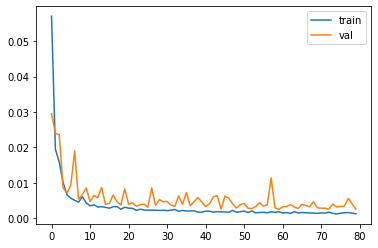

---Training time: 323.26347852 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.97608, Train (V) - 0.89836
R2 scores: Validation (SS) - 0.94965, Validation (V) - 0.83564
R2 scores: Testing (SS) - 0.88923, Testing (V) - 0.67229
RMSE scores: Train (SS) - 0.03132, Train (V) - 0.03640
RMSE scores: Validation (SS) - 0.04996, Validation (V) - 0.05278
RMSE scores: Testing (SS) - 0.07261, Testing (V) - 0.07241


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

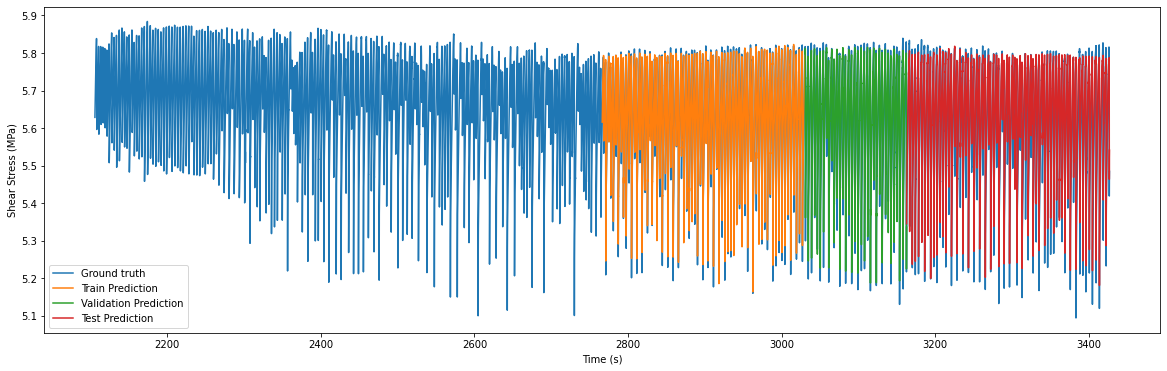

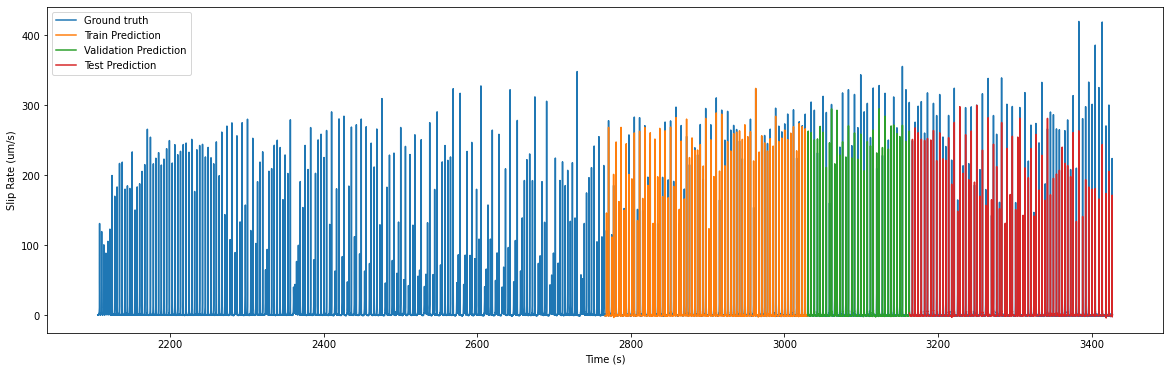

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[66049:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

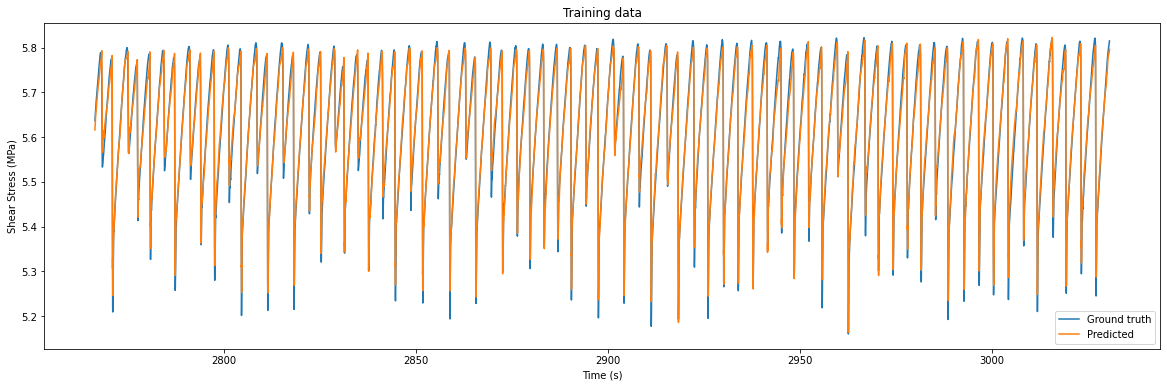

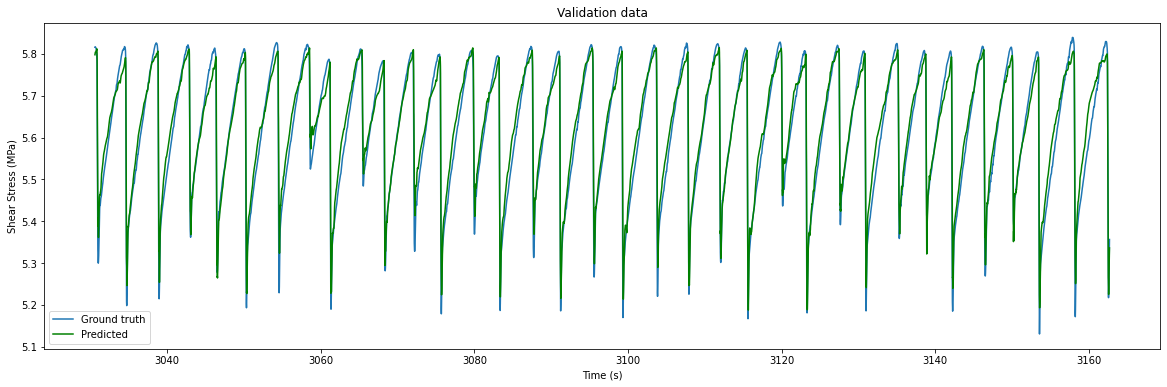

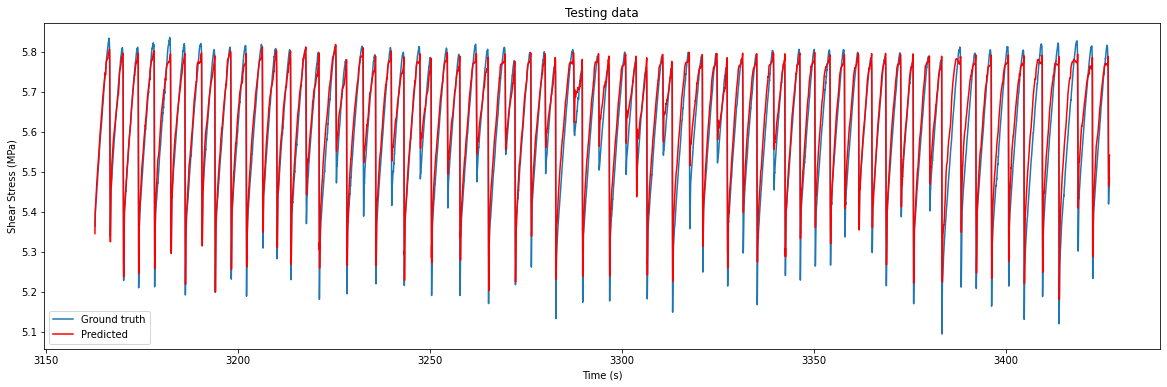

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

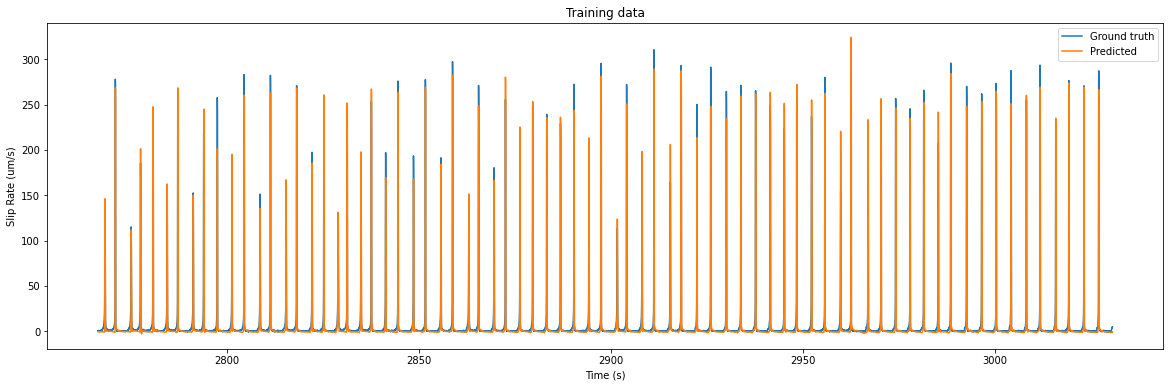

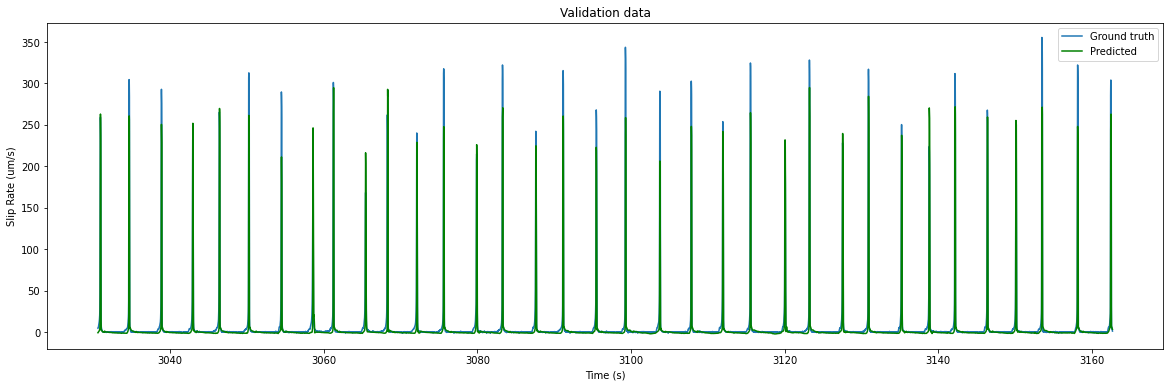

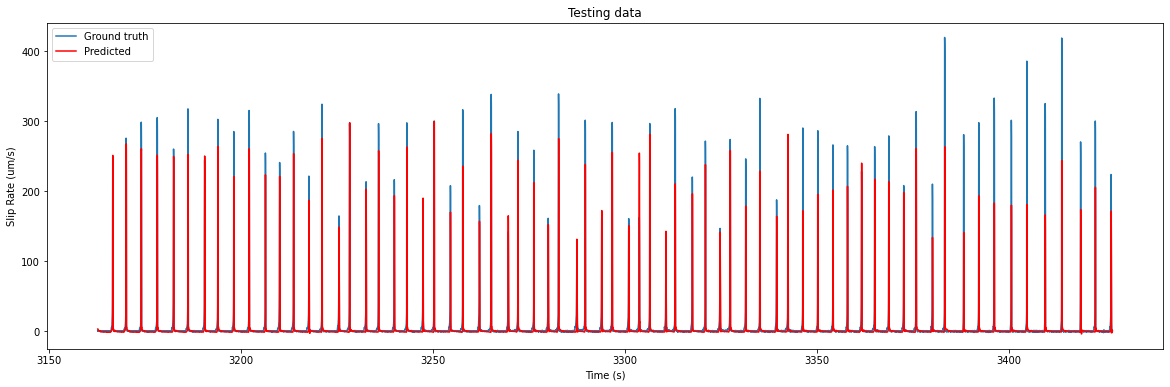

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')